# Tabular Playground Series - August 2022

In [ ]:
# version 3. Deeper prelimirary analysis. ###Missing values imputation + nnumerical features + easy prediction with XGBRegressor

# Score: ###0.58009

In [2]:
#pip install xgboost --upgrade --user

References:


In [3]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score  #, accuracy_score, f1_score

import xgboost as xgb

# 1. Loading datasets

In [4]:
# Set the working directory
os.chdir("C:\\_Kaggle\\Playground - Aug 2022\\data")

## 1.1. Load data and verify

In [5]:
# Load the train dataset
train_df = pd.read_csv('train.csv', sep=',', encoding='UTF-8', index_col='id')

print(f'Train: dimensions {train_df.shape}')
train_df.head()

Train: dimensions (26570, 25)


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [6]:
# Load the test dataset
test_df = pd.read_csv('test.csv', sep=',', encoding='UTF-8', index_col='id')

print(f'Test: dimensions {test_df.shape}')
test_df.head()

Test: dimensions (20775, 24)


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
26570,F,119.57,material_5,material_6,6,4,6,9,6,19.305,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
26571,F,113.51,material_5,material_6,6,4,11,8,0,17.883,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
26572,F,112.16,material_5,material_6,6,4,8,12,4,18.475,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
26573,F,112.72,material_5,material_6,6,4,8,11,10,16.518,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
26574,F,208.00,material_5,material_6,6,4,14,16,8,17.808,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


## 1.2. Concatenate datasets

In order to make easier the data analysis and the feature engineering, better merge both datasets.

In [7]:
# First, let's check the target variable:
train_df['failure'].unique()

array([0, 1], dtype=int64)

In [8]:
# There is only 2 values, so I assign a '2' as a dummy value:
test_df['failure'] = 2

In [9]:
# Now, both datasets have the same columns, so I can concatenate them:
combi_df = pd.concat([train_df, test_df])

# Verify lengths:
print(len(train_df))
print(len(test_df))
print(len(combi_df))

26570
20775
47345


In [10]:
# I create a 'rowid' column for graphical representations
combi_df['rowid'] = combi_df.index

# 2. Preliminary analysis

First checks of the data to analize tha data quality, data types, missing values and outliers, patterns, ... The purpose is to have an idea of the data in order to be able to define what kind of data transformation may be needed.

## 2.1. Look for duplicates

In [11]:
# Check number of duplicates while ignoring the index feature
combi_df.duplicated().sum()

# In case of duplicates, only those fron the train dataset can be removed.

0

## 2.2. Cardinality and data types

In [12]:
# Let's validate the unique values:
combi_df.nunique()

product_code          9
loading           14652
attribute_0           2
attribute_1           4
attribute_2           5
attribute_3           6
measurement_0        31
measurement_1        33
measurement_2        28
measurement_3      5190
measurement_4      5185
measurement_5      5199
measurement_6      5198
measurement_7      5207
measurement_8      5188
measurement_9      5189
measurement_10     7291
measurement_11     7454
measurement_12     7105
measurement_13     6393
measurement_14     7198
measurement_15     7452
measurement_16     7874
measurement_17    41261
failure               3
rowid             47345
dtype: int64

In [13]:
'''
# Graphical version

# For each numerical feature compute number of unique entries
unique_values = combi_df.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature", alpha=0.5);
'''

'\n# Graphical version\n\n# For each numerical feature compute number of unique entries\nunique_values = combi_df.select_dtypes(include="number").nunique().sort_values()\n\n# Plot information with y-axis in log-scale\nunique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature", alpha=0.5);\n'

In [14]:
# Make groups of columns, acconding to the cardinality and datatype:
cols_categories = ['product_code', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']
combi_df[cols_categories] = combi_df[cols_categories].astype(str)

cols_continuous = ['loading', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 
                   'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 
                   'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']

## 2.3. Missing values

In [15]:
combi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47345 entries, 0 to 47344
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    47345 non-null  object 
 1   loading         46872 non-null  float64
 2   attribute_0     47345 non-null  object 
 3   attribute_1     47345 non-null  object 
 4   attribute_2     47345 non-null  object 
 5   attribute_3     47345 non-null  object 
 6   measurement_0   47345 non-null  int64  
 7   measurement_1   47345 non-null  int64  
 8   measurement_2   47345 non-null  int64  
 9   measurement_3   46635 non-null  float64
 10  measurement_4   46398 non-null  float64
 11  measurement_5   46161 non-null  float64
 12  measurement_6   45925 non-null  float64
 13  measurement_7   45688 non-null  float64
 14  measurement_8   45451 non-null  float64
 15  measurement_9   45214 non-null  float64
 16  measurement_10  44978 non-null  float64
 17  measurement_11  44741 non-null 

In [16]:
# There are some missing values. Let's see the proportion:
total = len(combi_df)
combi_df.isna().sum()/total

product_code      0.000000
loading           0.009990
attribute_0       0.000000
attribute_1       0.000000
attribute_2       0.000000
attribute_3       0.000000
measurement_0     0.000000
measurement_1     0.000000
measurement_2     0.000000
measurement_3     0.014996
measurement_4     0.020002
measurement_5     0.025008
measurement_6     0.029993
measurement_7     0.034998
measurement_8     0.040004
measurement_9     0.045010
measurement_10    0.049995
measurement_11    0.055001
measurement_12    0.060006
measurement_13    0.064991
measurement_14    0.069997
measurement_15    0.075003
measurement_16    0.080008
measurement_17    0.084993
failure           0.000000
rowid             0.000000
dtype: float64

In [17]:
'''
# Sorted in a bar graphic
combi_df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), alpha=.5, 
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");
'''

'\n# Sorted in a bar graphic\ncombi_df.isna().mean().sort_values().plot(\n    kind="bar", figsize=(15, 4), alpha=.5, \n    title="Percentage of missing values per feature",\n    ylabel="Ratio of missing values per feature");\n'

<AxesSubplot:>

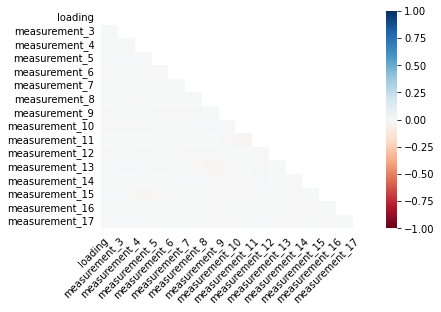

In [18]:
# 2 thirds of the features have messing values, but at the most, it is a 8.5%. Let's see if there is recognizable distribution:
msno.heatmap(combi_df, figsize=(6,4), fontsize=10)

In [19]:
# Conclusions:
# There is no relationship among the missing values. I have to deal with them individualy.

## 2.4. Value distribution

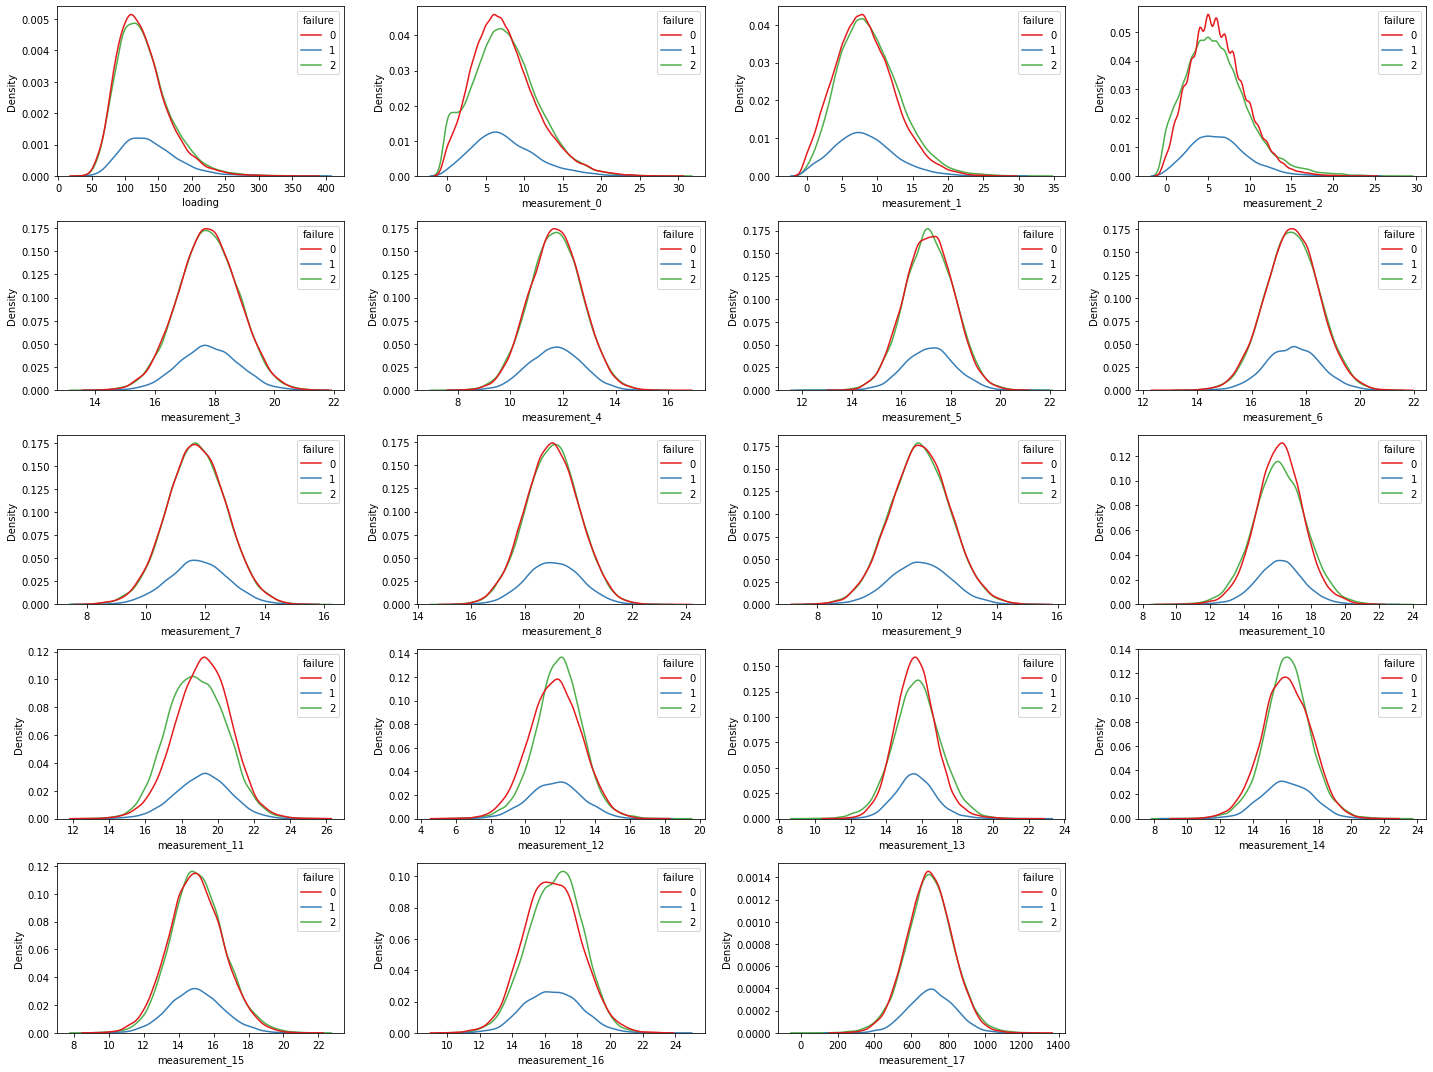

In [20]:
# Features with several values (numerical)

fig = plt.figure(figsize=(20,15))
          
for i,f in enumerate(cols_continuous):
    plt.subplot(5, 4, i+1)
    sns.kdeplot(data=combi_df, x=f, hue='failure', fill=False, palette='Set1')
    plt.xlabel(f)

plt.tight_layout()    
plt.show()


In [21]:
# Conclusions:
# The distributions are very alike, so no insight can be excracted.

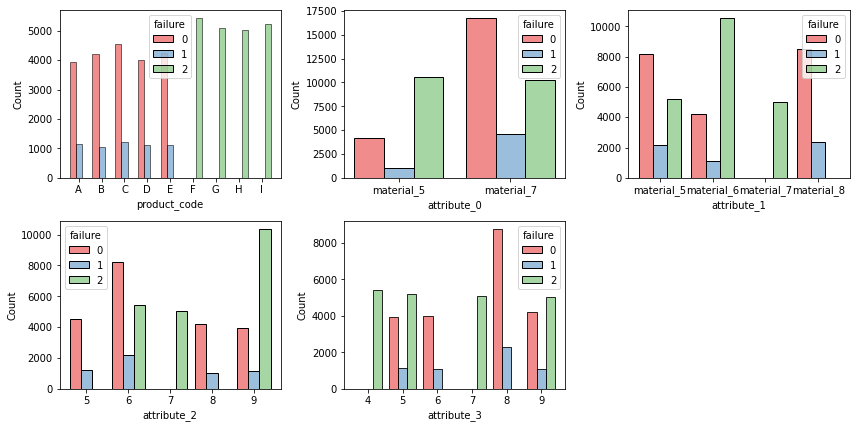

In [22]:
# Categorical features

fig = plt.figure(figsize=(12,6))
          
for i,f in enumerate(cols_categories):
    plt.subplot(2, 3, i+1)
    sns.histplot(combi_df.sort_values(by=f), x=f, hue='failure', multiple='dodge', shrink=.8, palette='Set1', alpha=0.5)
    plt.xlabel(f)

plt.tight_layout()    
plt.show()

In [23]:
# Conclusions:
# Product code: must be discarded

## 2.5. Data distribution in dataset

Complementary value distribution analysis to know better the data and to identify unwanted entries or recording errors.

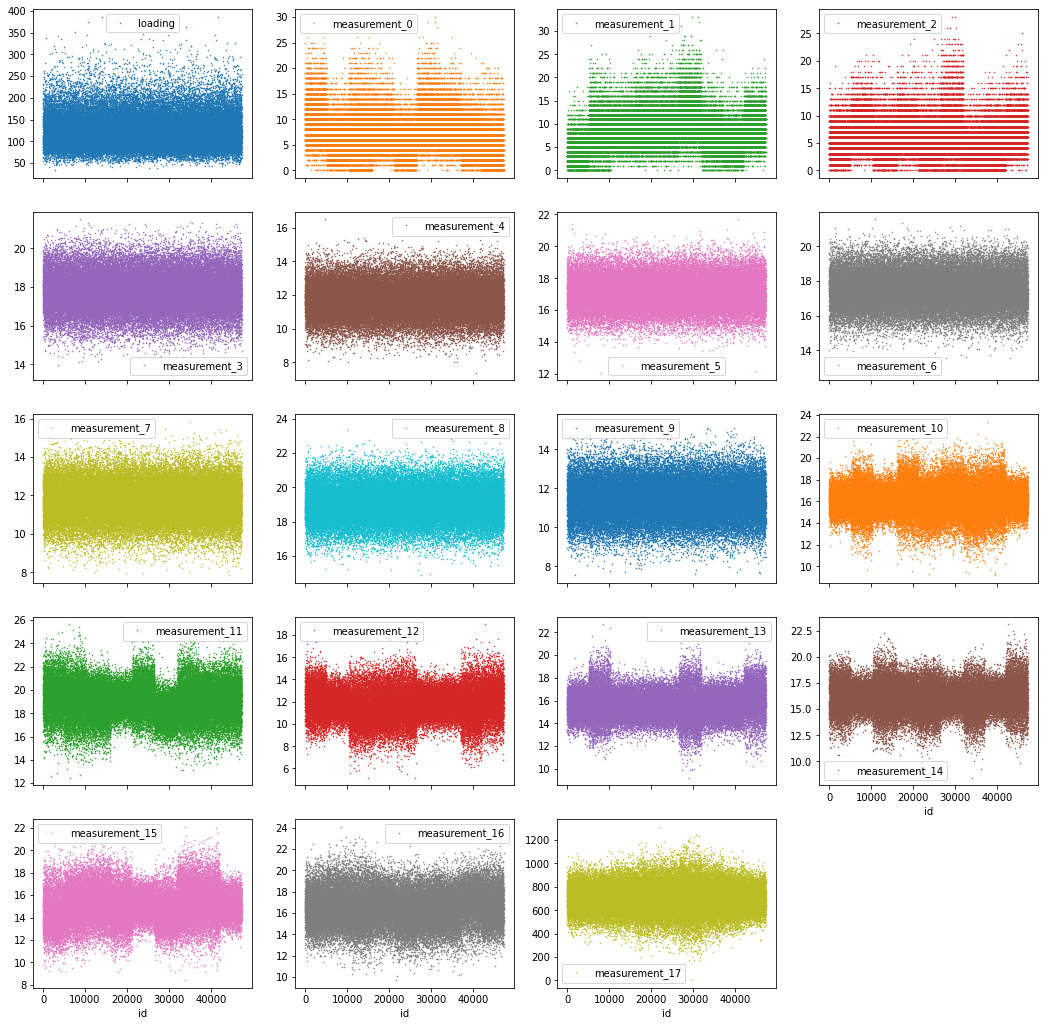

In [24]:
# Continuous variables
combi_df[cols_continuous].plot(lw=0, 
                               marker=".", 
                               subplots=True, 
                               layout=(-1, 4), 
                               figsize=(18, 18), 
                               markersize=1);

In [25]:
# Conclusions
# We can see vertical bands in several of features. I must inverstigate.

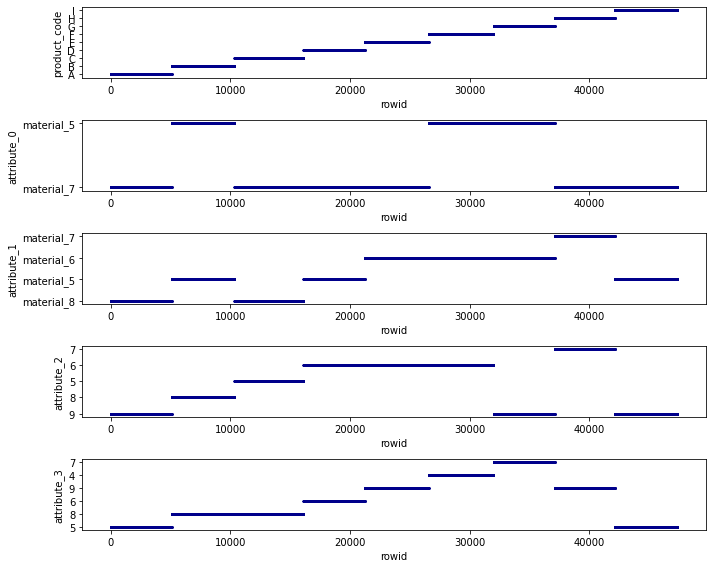

In [26]:
# Categorical features
fig, axes = plt.subplots(ncols=1, nrows=5, figsize=(10, 8))

for c, ax in zip(combi_df[cols_categories].columns, axes.ravel()):
    combi_df.plot.scatter(x='rowid', y=c, c='DarkBlue', s=1, ax=ax)
    
plt.tight_layout();

In [27]:
# Conclusions
# From the 'product_code' distribution we can see the origin of the vertical bands in the continuous features graphics.

## 2.6. Outliers

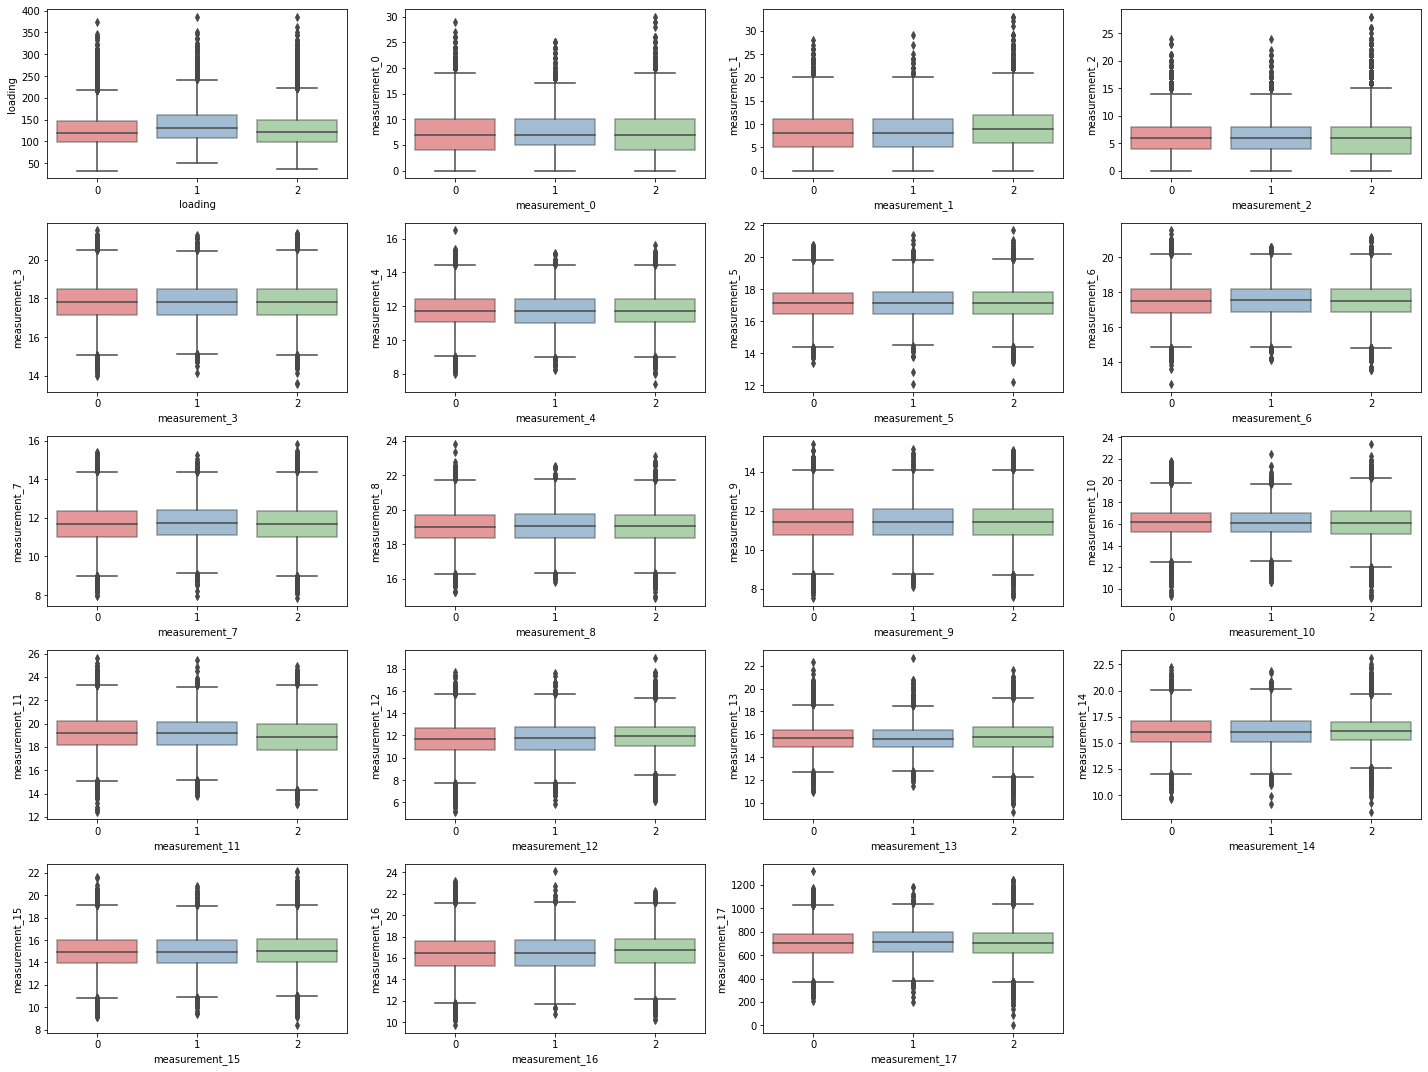

In [28]:
fig = plt.figure(figsize=(20,15))
          
for i,f in enumerate(cols_continuous):
    plt.subplot(5, 4, i+1)
    sns.boxplot(data=combi_df, x='failure', y=f, palette='Set1', boxprops=dict(alpha=.5))
    plt.xlabel(f)

plt.tight_layout()    
plt.show()

In [29]:
# Conclusions:
# Every feature has extreme values, but none to take care about.

## 2.7. Feature correlation

<AxesSubplot:>

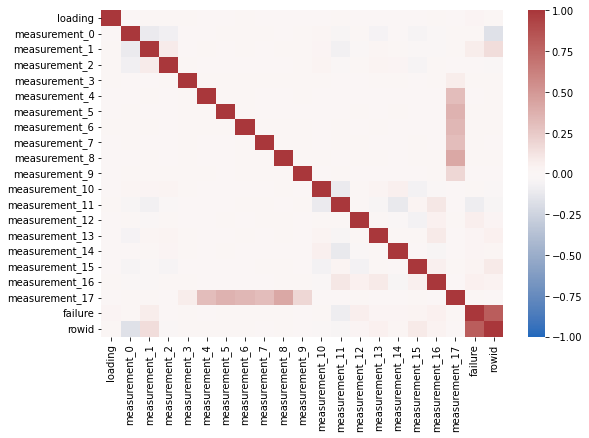

In [30]:
# Continuous variables
# Let's check the correlation among the numeric features
plt.figure(figsize=(9, 6))
sns.heatmap(combi_df.corr(), vmin=-1, vmax=1, cmap='vlag')

In [31]:
'''
# Going deeper ...
sns.pairplot(combi_df[cols_continuous], height=1.5, plot_kws={"s": 2, "alpha": 0.2});
'''

'\n# Going deeper ...\nsns.pairplot(combi_df[cols_continuous], height=1.5, plot_kws={"s": 2, "alpha": 0.2});\n'

In [32]:
# Conclusions:
# There is a slight correlation between 'measurement_17' and 'measurement_4' to '_8', but I don't see it  significative.

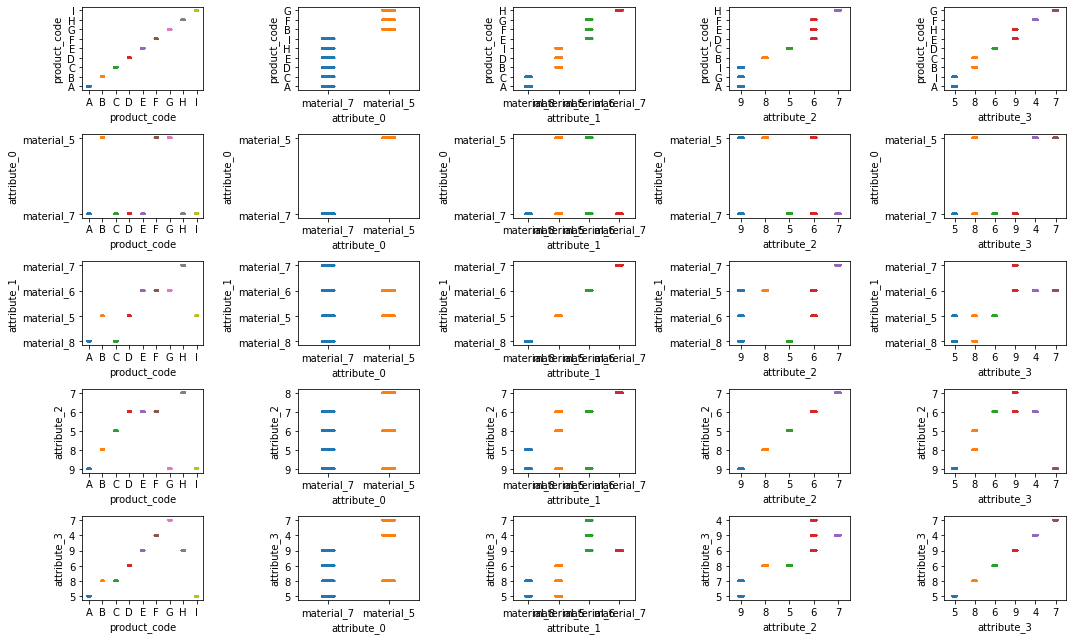

In [33]:
# Categorical features
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(15, 9))

for j, col_y in enumerate(cols_categories):
    for i, col_x in enumerate(cols_categories,):
        plt.subplot(5, 5, 5*(j) + i+1)
        sns.stripplot(data=combi_df, x=col_x, y=col_y,
                      palette="tab10", size=2, alpha=0.5)
    
plt.tight_layout()   
plt.show()

In [34]:
# Conclusions:
# There a correlation between some of the discrete variables.

## 2.8. Conclusions and actions

Insights:
* The amount of missing values is very low. We can impute the missing data.
* I have divided the columns in 2 types, categorical and numerical.
* The value distributions doesn't tell much. I've discarded 'product_code' column.
* No significant outliers.
* There is no significant correlation among features.

# 3. Feature engineering

## 3.1. Missing values

As we can see in the point 2.3, values are concentrated around a central point. I use the median to impute the missing values.

In [35]:
# Get the columns with missing values
cols_nan = [i for i in combi_df.columns if combi_df[i].isnull().sum() > 0]

# Impute with the median
for c in cols_nan:
    combi_df[c].fillna((combi_df[c].median()), inplace=True)

# 4. Build the model

## 4.1. Prepare the train, validation and test datasets

In [36]:
# In this version, I'll use only the numerical variables
cols_selected = cols_continuous + ['failure']
combi_pred = combi_df[cols_selected].copy()

In [37]:
# Training and validation sets
train_final = combi_pred[combi_pred['failure'] < 2].copy()

train_set, validation_set = train_test_split(train_final, test_size=0.2, random_state=666)  
X_train = train_set.loc[:, train_set.columns != 'failure']
y_train = train_set['failure']

X_validation = validation_set.loc[:, validation_set.columns != 'failure']
y_validation = validation_set['failure']

# Testing set
test_final = combi_pred[combi_pred['failure'] == 2].copy()
test_final.drop('failure', axis=1, inplace=True)
X_test = test_final

# Resume
print(len(combi_pred), "combi_pred")
print(len(X_train), "X_train")
print(len(X_validation), " X_validation")
print(len(X_test), "X_test")

47345 combi_pred
21256 X_train
5314  X_validation
20775 X_test


## 4.2. Build and execute the model

In [38]:
# Build the model
xgb_model = xgb.XGBRegressor(n_estimators=10,
                             max_depth=3,
                             objective='binary:logistic',
                             eval_metric='logloss',
                             n_jobs=-1,
                             random_state=101)

# Train the model
xgb_fit = xgb_model.fit(X_train, y_train)

In [39]:
# Make prediction
predicted_train = xgb_model.predict(X_train)
predicted_validation = xgb_model.predict(X_validation)

# Evaluate prediction
print(f"roc_auc_score for train = {roc_auc_score(y_train, predicted_train)}")
print(f"roc_auc_score for validation = {roc_auc_score(y_validation, predicted_validation)}")

roc_auc_score for train = 0.6168543595632378
roc_auc_score for validation = 0.5897518646012623


# 5. Make output file

In [40]:
# Load the sample file
submission = pd.read_csv('sample_submission.csv', sep=',', encoding='UTF-8', index_col='id')
submission['failure'] = xgb_model.predict(X_test)
submission.to_csv('submission.csv')

In [41]:
# Check result
submission

,failure
id,
26570,0.194314
26571,0.186019
26572,0.184619
26573,0.176647
26574,0.298460
...,...
47340,0.221035
47341,0.144488
47342,0.154228
